# 🛍️ Sales Forecast Report - Fashion Store

This notebook reads fashion sales data, performs a forecast using Facebook Prophet,
and generates a professional PDF report with charts, product analysis and insights.

In [1]:
%pip install pandas prophet plotly fpdf

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install kaleido

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Required libraries
import pandas as pd
from prophet import Prophet
import plotly.graph_objects as go
import plotly.io as pio
from fpdf import FPDF
from datetime import datetime

# Load dataset
df = pd.read_csv("fashion_sales_data_super_boosted.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate revenue per day
daily_sales = df.groupby("Date")["Total Revenue"].sum().reset_index()
daily_sales.columns = ["ds", "y"]

d:\User\Desktop\projects\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Forecasting with Prophet
model = Prophet()
model.fit(daily_sales)

# Create future dataframe (next 60 days)
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Plot forecast with Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Forecast'))
fig.add_trace(go.Scatter(x=daily_sales['ds'], y=daily_sales['y'], name='Actual'))
fig.update_layout(title="Sales Forecast", xaxis_title="Date", yaxis_title="Revenue")

# Save plot as image
plot_path = "forecast_plot.png"
pio.write_image(fig, plot_path, format='png')

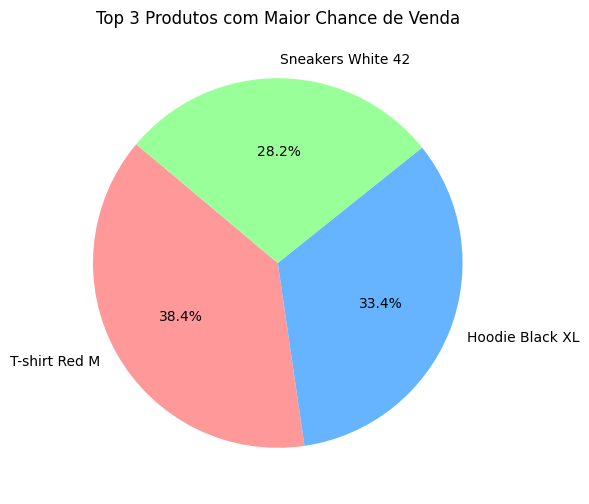

In [6]:
import matplotlib.pyplot as plt

# Dados dos top 3 produtos com maiores Forecast_Quantity
labels = ['T-shirt Red M', 'Hoodie Black XL', 'Sneakers White 42']
quantities = [1526.76, 1328.25, 1118.69]

# Criar gráfico de pizza
fig, ax = plt.subplots(figsize=(6, 6))
colors = ['#FF9999', '#66B3FF', '#99FF99']
ax.pie(quantities, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
ax.set_title('Top 3 Produtos com Maior Chance de Venda')

# Salvar imagem
plt.savefig('pizza_top3_produtos.png', bbox_inches='tight')
plt.show()


In [7]:
# Criar dataframe com todas as previsões
forecast_df = pd.DataFrame()

for product in df['Product'].unique():
    product_data = df[df['Product'] == product]
    product_data = product_data.groupby('Date').agg({'Quantity': 'sum'}).reset_index()
    product_data.columns = ['ds', 'y']

    model = Prophet()
    model.fit(product_data)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    forecast['Product'] = product
    forecast_df = pd.concat([forecast_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Product']]])


DEBUG	Task(Task-3) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-3) cmdstanpy:model.py:__init__()- TBB already found in load path
INFO	Task(Task-3) prophet:forecaster.py:parse_seasonality_args()- Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO	Task(Task-3) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-3) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Work\AppData\Local\Temp\tmpzsdzc7w_\zf5sl0x7.json
DEBUG	Task(Task-3) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\Work\AppData\Local\Temp\tmpzsdzc7w_\86gq7t4v.json
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-3) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['D:\\User\\Desktop\\projects

In [8]:
# Vendas atuais (históricas) por produto
current_sales = df.groupby('Product')['Quantity'].sum().to_dict()

In [9]:
# Resumo por produto
forecast_summary = forecast_df[forecast_df['ds'] > df['Date'].max()]  # só as datas futuras
product_summary = forecast_summary.groupby('Product')['yhat'].sum().reset_index()
product_summary.columns = ['Product', 'Forecast_Quantity']

# Adiciona variação percentual
product_summary['Current_Sales'] = product_summary['Product'].map(current_sales)
product_summary['Percent_Change'] = ((product_summary['Forecast_Quantity'] - product_summary['Current_Sales']) / product_summary['Current_Sales']) * 100
product_summary['Percent_Change'] = product_summary['Percent_Change'].round(1)

# Salvar CSV
product_summary.to_csv("product_forecast_summary.csv", index=False)

In [10]:
# Load product forecast summary table
summary_df = pd.read_csv("product_forecast_summary.csv")

In [12]:
from fpdf import FPDF
from datetime import datetime
import os

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 18)
        self.set_text_color(64, 0, 128) #####
        self.cell(0, 15, 'SALES FORECAST REPORT - FASHION STORE', 0, 1, 'C')
        
        self.set_draw_color(64, 0, 128) #####
        self.set_line_width(0.6)
        self.line(15, self.get_y(), 195, self.get_y())
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128, 128, 128)
        generated_at = datetime.now().strftime("%d/%m/%Y at %H:%M")
        self.cell(0, 10, f'Generated on {generated_at}', 0, 0, 'L')
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'R')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 14)
        self.set_text_color(38, 0, 77) #####
        self.set_fill_color(236, 240, 241)
        self.cell(0, 10, title, 0, 1, 'L', 1)
        self.ln(4)

    def add_info_box(self, label, value):
        self.set_font('Arial', 'B', 11)
        self.set_text_color(38, 0, 77) #####
        self.cell(70, 8, label + ":", 0, 0, "L")
        self.set_font("Arial", "", 11)
        self.set_text_color(0, 0, 0)
        self.cell(0, 8, str(value), 0, 1, "L")

    def create_table_header(self, headers, widths):
        self.set_font('Arial', 'B', 12)
        self.set_fill_color(64, 0, 128) #####
        self.set_text_color(255, 255, 255)
        self.set_draw_color(255, 255, 255)
        for i, header in enumerate(headers):
            self.cell(widths[i], 11, header, 1, 0, 'C', 1)
        self.ln()

    def create_table_row(self, data, widths, fill=False, percent_change=None):
        self.set_font('Arial', '', 11)
        self.set_text_color(0, 0, 0)
        self.set_fill_color(248, 249, 250) if fill else self.set_fill_color(255, 255, 255)
        self.set_draw_color(220, 220, 220)
        
        self.cell(widths[0], 9, data[0], 1, 0, 'L', 1)
        self.cell(widths[1], 9, data[1], 1, 0, 'C', 1)
        
        if percent_change is not None:
            if percent_change > 0:
                self.set_text_color(0, 150, 0)
            elif percent_change < 0:
                self.set_text_color(200, 0, 0)
            else:
                self.set_text_color(0, 0, 0)
        self.cell(widths[2], 9, data[2], 1, 1, 'C', 1)
        self.set_text_color(0, 0, 0)


def generate_pdf(summary_df, forecast_days=60, output_filename="sales_forecast_report.pdf"):
    pdf = PDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    # GENERAL INFO
    pdf.chapter_title("GENERAL INFORMATION")
    pdf.add_info_box("Generation Date", datetime.now().strftime("%d/%m/%Y"))
    pdf.add_info_box("Forecast Period", f"{forecast_days} days")
    pdf.add_info_box("Total Products", len(summary_df))

    # Total Forecast Sales
    total_sales = summary_df["Forecast_Quantity"].sum()
    pdf.add_info_box("Total Forecast Sales", f"{total_sales:.2f} units")

    pdf.ln(10)

    # Observations
    pdf.set_font("Arial", "", 12)
    observations = (
        f"This report provides a sales forecast for the next {forecast_days} days based on historical data.\n"
        "Use this information to plan marketing campaigns, optimize inventory levels, and make data-driven financial decisions."
    )
    pdf.multi_cell(0, 9, observations)
    pdf.ln(8)

    # Graph
    if os.path.isfile("forecast_plot.png"):
        pdf.image("forecast_plot.png", w=180)
        pdf.ln(10)

    if os.path.isfile("pizza_top3_produtos.png"):
        pdf.image("pizza_top3_produtos.png", w=180)
        pdf.ln(10)

    # PRODUCT FORECAST TABLE
    pdf.add_page() 
    pdf.chapter_title("PRODUCT FORECAST SUMMARY")
    headers = ["Product", "Forecast Quantity", "% Change"]
    widths = [90, 45, 45]
    pdf.create_table_header(headers, widths)

    for idx, row in summary_df.iterrows():
        product = str(row['Product'])[:40]
        forecast_qty = f"{row['Forecast_Quantity']:.0f}"
        percent = row['Percent_Change']
        percent_str = f"{percent:.1f}%"
        fill = (idx % 2 == 0)
        pdf.create_table_row([product, forecast_qty, percent_str], widths, fill, percent_change=percent)

    # STATISTICAL SUMMARY PAGE
    pdf.add_page()
    pdf.chapter_title("STATISTICAL SUMMARY")

    # Calculations
    values = summary_df["Forecast_Quantity"]
    avg = values.mean()
    max_val = values.max()
    min_val = values.min()
    best_product = summary_df.loc[values.idxmax()]['Product']

    pdf.add_info_box("Average Sales by Product", f"{avg:.2f} units")
    pdf.add_info_box("Highest Individual Forecast", f"{max_val:.2f} units")
    pdf.add_info_box("Lowest Individual Forecast", f"{min_val:.2f} units")
    pdf.add_info_box("Product with Best Performance", str(best_product))

    pdf.ln(10)
    pdf.set_font('Arial', 'I', 9)
    pdf.set_text_color(128, 128, 128)
    pdf.multi_cell(0, 5,
        "This report was automatically generated based on predictive analysis.\n"
        "Values are estimates and may vary according to historical sales data."
    )

    pdf.output(output_filename)
    print(f"✅ Professional-looking PDF generated: {output_filename}")

# Exemplo de uso:
generate_pdf(summary_df)


✅ Professional-looking PDF generated: sales_forecast_report.pdf


In [26]:
%pip list --format=freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
